#bike


In [1]:

import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

data = pd.read_csv("https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/bike_pm2.5/SeoulBikeData%20(1).csv?token=GHSAT0AAAAAABQVZROYVL2O4C55SS6EGP7GYPPPGVQ")

In [2]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad

def int_gradient(seq, model, epsil = 0.2):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    
    grad = tape.gradient(predictions, seq)
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [3]:
data['Holiday']=data['Holiday'].factorize()[0]

In [4]:
data['Seasons']=data['Seasons'].factorize()[0]
data['Functioning Day']=data['Functioning Day'].factorize()[0]

In [5]:
data['Rented Bike Count']

0        254
1        204
2        173
3        107
4         78
        ... 
8755    1003
8756     764
8757     694
8758     712
8759     584
Name: Rented Bike Count, Length: 8760, dtype: int64

In [6]:
data=data.drop(['Hour'],axis=1)

In [7]:
data.columns[1:-3]

Index(['Rented Bike Count', 'Temperature', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

In [8]:
cols=data.columns[1:-3] 
len(cols)

9

In [9]:
from sklearn.preprocessing import MinMaxScaler
values = data[cols].values.reshape(-1,9)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values) 

In [73]:
scaled.shape

(8760, 9)

In [10]:
np.max(values)

3556.0

In [11]:
np.min(values)

-30.6

In [12]:
np.max(values)-np.min(values)

3586.6

In [13]:
'''
from sklearn.preprocessing import MinMaxScaler
values = data[cols].values.reshape(-1,9)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) 
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\nvalues = data[cols].values.reshape(-1,9)\nvalues = values.astype('float32')\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled = scaler.fit_transform(values) \n"

In [14]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 7 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if values[row,0]==0:
                values[row,0] = values[row - one_day,0]

In [15]:
fill_missing(values)

In [16]:
sum(pd.DataFrame(values)[0]==0)

0

In [17]:

train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

7008 876 876


In [75]:
test.shape

(876, 9)

In [18]:

def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back-1: i+ look_back+predict-1, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [19]:
look_back = 168
predict=24

trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

6816
684
684


In [61]:
testX.shape

(684, 168, 9)

In [77]:
testY.shape

(684, 24)

In [20]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [21]:
def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    seq_input = X_test[1]

    if baseline is None:
        baseline = np.zeros(seq_input.shape).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)
    #baseline = tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)
    # 1. Do interpolation.
    seq_input = seq_input.astype(np.float32)
    interpolated_seq = [
        baseline + (step / num_steps) * (seq_input - baseline)
        for step in range(num_steps + 1)
    ]

    # 3. Get the gradients
    grads = []
    for i, seq in enumerate(interpolated_seq):
        seq = tf.expand_dims(seq, axis=0)
        with tf.GradientTape() as tape:
            tape.watch(seq)
            preds = model(seq)
        grad = tape.gradient(preds, seq)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (seq_input - baseline) * avg_grads
    return integrated_grads

In [21]:
def get_integrated_gradients_r(img_input, top_pred_idx, baseline1=None, num_steps=50):
    seq_input = X_test[1]

    baseline1 = tf.random.uniform(seq_input.shape, minval=0.0, maxval=1.0)
    # 1. Do interpolation.
    seq_input = seq_input.astype(np.float32)
    interpolated_seq = [
        baseline1 + (step / num_steps) * (seq_input - baseline1)
        for step in range(num_steps + 1)
    ]

    # 3. Get the gradients
    grads = []
    for i, seq in enumerate(interpolated_seq):
        seq = tf.expand_dims(seq, axis=0)
        with tf.GradientTape() as tape:
            tape.watch(seq)
            preds = model(seq)
        grad = tape.gradient(preds, seq)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (seq_input - baseline1) * avg_grads
    return integrated_grads

In [46]:
def get_integrated_gradients_m(img_input, top_pred_idx, baseline2=None, num_steps=50):
    seq_input = X_test[1]
    
    mean = np.nanmean(seq_input)
    baseline2 = np.full(seq_input.shape, mean)
    # 1. Do interpolation.
    seq_input = seq_input.astype(np.float32)
    interpolated_seq = [
        baseline2 + (step / num_steps) * (seq_input - baseline2)
        for step in range(num_steps + 1)
    ]

    # 3. Get the gradients
    grads = []
    for i, seq in enumerate(interpolated_seq):
        seq = tf.expand_dims(seq, axis=0)
        with tf.GradientTape() as tape:
            tape.watch(seq)
            preds = model(seq)
        grad = tape.gradient(preds, seq)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (seq_input - baseline2) * avg_grads
    return integrated_grads

In [22]:
X_test=testX.copy()

In [23]:
seq_input = X_test[1]
baseline = np.zeros(seq_input.shape).astype(np.float32)

In [24]:
baseline

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
X_test=testX.copy()

In [26]:
X_test[1]

array([[0.32452196, 0.6503496 , 0.3265306 , ..., 0.65625   , 0.        ,
        0.        ],
       [0.33520812, 0.67132866, 0.31632653, ..., 0.48295456, 0.        ,
        0.        ],
       [0.35854894, 0.67132866, 0.3265306 , ..., 0.39772725, 0.        ,
        0.        ],
       ...,
       [0.19572555, 0.45279717, 0.52040815, ..., 0.39204544, 0.        ,
        0.        ],
       [0.23959506, 0.50524473, 0.46938774, ..., 0.52272725, 0.        ,
        0.        ],
       [0.26040497, 0.5314685 , 0.36734694, ..., 0.60795456, 0.        ,
        0.        ]], dtype=float32)

In [27]:
X_test[1].shape

(168, 9)

In [28]:
seq_input = X_test[1]
baseline1 = tf.random.uniform(seq_input.shape, minval=0.0, maxval=1.0)

In [29]:
baseline1

<tf.Tensor: shape=(168, 9), dtype=float32, numpy=
array([[0.32425988, 0.30326593, 0.9793682 , ..., 0.40116632, 0.45058763,
        0.10166597],
       [0.07455695, 0.0406177 , 0.5812458 , ..., 0.50600576, 0.5060812 ,
        0.05423021],
       [0.2887354 , 0.71463823, 0.93887115, ..., 0.03101778, 0.49876451,
        0.31717467],
       ...,
       [0.6001409 , 0.8291719 , 0.77775335, ..., 0.08336818, 0.4970516 ,
        0.5757915 ],
       [0.28394234, 0.3835882 , 0.5365218 , ..., 0.1589942 , 0.49074006,
        0.18231642],
       [0.33084416, 0.9069822 , 0.3990755 , ..., 0.8349179 , 0.6472664 ,
        0.23515701]], dtype=float32)>

In [30]:
mean = np.nanmean(seq_input)
baseline2 = np.full(seq_input.shape, mean)

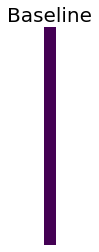

In [31]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

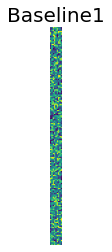

In [32]:
plt.imshow(baseline1)
plt.title("Baseline1")
plt.axis('off')
plt.show()

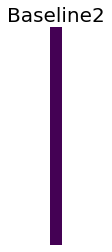

In [33]:
plt.imshow(baseline2)
plt.title("Baseline2")
plt.axis('off')
plt.show()

In [34]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [35]:
from tensorflow.keras.models import Model

cnn-lstm

In [47]:
first_input = Input(shape=(168,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100, return_sequences=False)(in1)
#in1=RepeatVector(24)(in1)
#in1=LSTM(50, return_sequences=True)(in1)
#in1=Dropout(0.3)(in1)
in1=Dense(100)(in1)
#in1=RepeatVector(24)(in1)

in1=Dropout(0.3)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_1cnnlstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY, epochs=30, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [48]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_1cnnlstm.hdf5")

### zero

(168, 9)


<Figure size 432x1440 with 0 Axes>

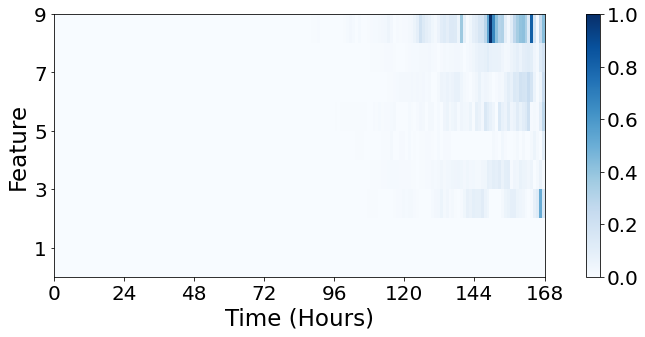

In [41]:
id_=(24)*24+12
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

### random

(168, 9)


<Figure size 432x1440 with 0 Axes>

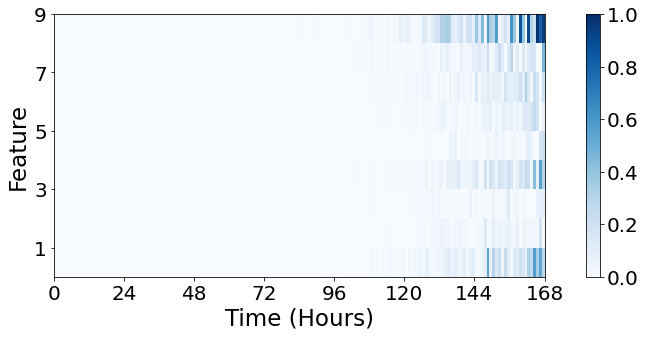

In [39]:
id_=(24)*24+12
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients_r(X_test[id_], model, baseline1 = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/bike_i_g_random_cnn-lstm.png')

### mean

(168, 9)


<Figure size 432x1440 with 0 Axes>

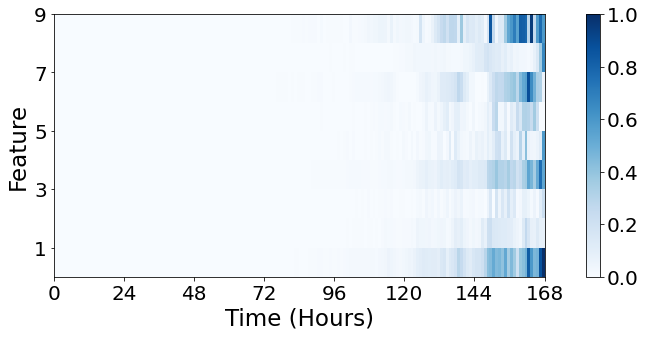

In [49]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients_m(X_test[id_], model, baseline2 = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/bike_i_g_mean_cnn-lstm.png')

lstm-cnn

In [50]:
first_input = Input(shape=(168,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)


#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)




in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_lstmcnn_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY,validation_data=[valX,valY],epochs=30, verbose=1, callbacks=[cb])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 168, 9)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 168, 64)           18944     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 168, 64)           12352     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 168, 64)           8256      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 168, 64)           4160      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 168, 64)           12352     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 168, 64)          

In [51]:
model.load_weights('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_lstmcnn_multi.hdf5')

(168, 9)


<Figure size 432x1440 with 0 Axes>

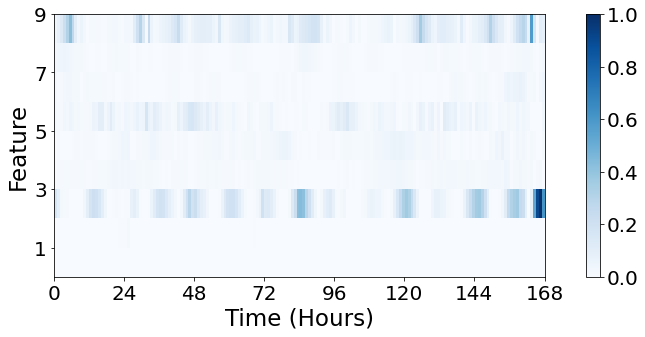

In [52]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

(168, 9)


<Figure size 432x1440 with 0 Axes>

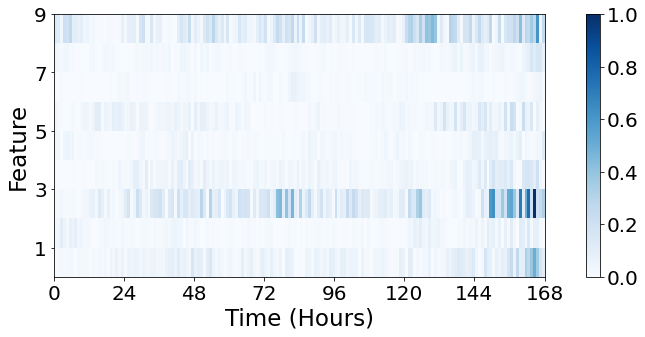

In [42]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients_r(X_test[id_], model, baseline1 = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/bike_i_g_random_lstm-cnn.png')

(168, 9)


<Figure size 432x1440 with 0 Axes>

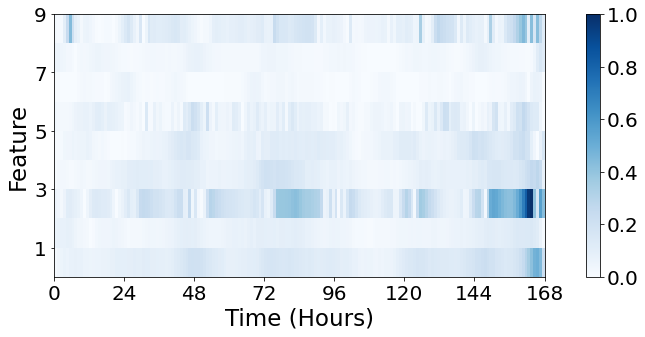

In [52]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients_m(X_test[id_], model, baseline2 = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/bike_i_g_mean_lstm-cnn.png')

lstm-rescnn

In [53]:
first_input = Input(shape=(168,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#ad1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_sizaae=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)

in1=Dropout(0.5)(in1)
out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_reslstmcnn_multi1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY,validation_data=[valX,valY],epochs=30, verbose=1,callbacks=[cb])

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 168, 9)]     0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 168, 64)      18944       input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 168, 64)      12352       lstm_5[0][0]                     
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 168, 64)      8256        conv1d_28[0][0]                  
______________________________________________________________________________________

In [54]:
model.load_weights('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_reslstmcnn_multi1.hdf5')

(168, 9)


<Figure size 432x1440 with 0 Axes>

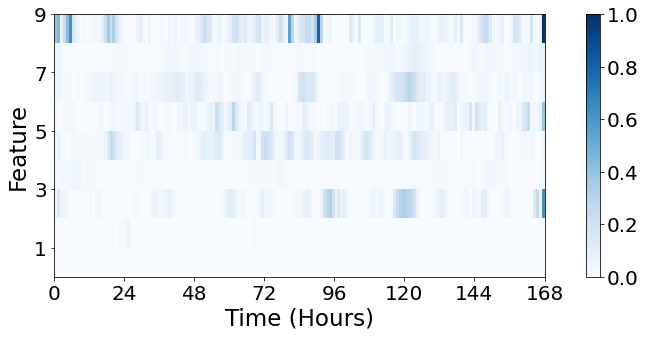

In [57]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

(168, 9)


<Figure size 432x1440 with 0 Axes>

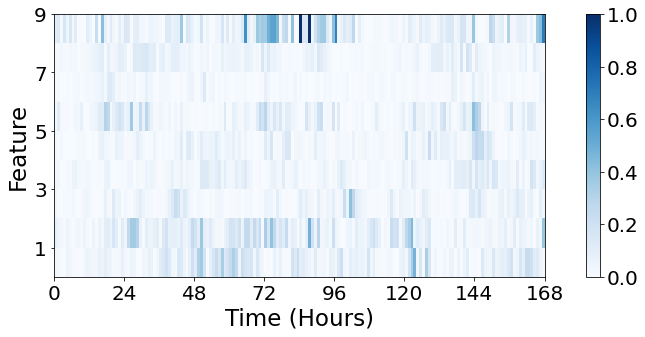

In [45]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients_r(X_test[id_], model, baseline1 = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/bike_i_g_random_lstm-rescnn.png')

(168, 9)


<Figure size 432x1440 with 0 Axes>

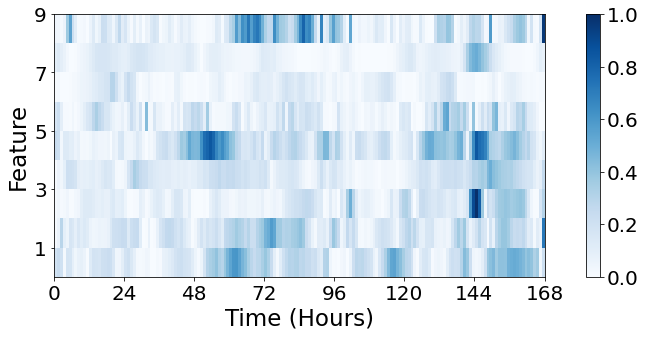

In [55]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients_m(X_test[id_], model, baseline2 = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/bike_i_g_mean_lstm-rescnn.png')

### i_g 데이터 확인

In [ ]:
id_=(24)*24+12
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-24*7])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)


plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

In [79]:
id_

588

In [82]:
print(len(train),len(val), len(test))

7008 876 876


In [83]:
7008+876+588

8472

In [89]:
8472+168

8640

In [91]:
X_test[id_]

array([[0.12851518, 0.43006992, 0.57142854, ..., 0.        , 0.        ,
        0.        ],
       [0.07789651, 0.41433564, 0.6122449 , ..., 0.        , 0.        ,
        0.        ],
       [0.05343082, 0.40559438, 0.6632653 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.15354331, 0.39335662, 0.8265306 , ..., 0.        , 0.        ,
        0.04545454],
       [0.13948257, 0.38461536, 0.83673465, ..., 0.        , 0.        ,
        0.04545454],
       [0.10658043, 0.37762237, 0.8469387 , ..., 0.        , 0.        ,
        0.04545454]], dtype=float32)

In [90]:
scaled[8472:8640]

array([[0.12851518, 0.43006992, 0.57142854, ..., 0.        , 0.        ,
        0.        ],
       [0.07789651, 0.41433564, 0.6122449 , ..., 0.        , 0.        ,
        0.        ],
       [0.05343082, 0.40559438, 0.6632653 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.15354331, 0.39335662, 0.8265306 , ..., 0.        , 0.        ,
        0.04545454],
       [0.13948257, 0.38461536, 0.83673465, ..., 0.        , 0.        ,
        0.04545454],
       [0.10658043, 0.37762237, 0.8469387 , ..., 0.        , 0.        ,
        0.04545454]], dtype=float32)

In [99]:
data_1=data.drop(['Seasons','Holiday','Functioning Day'],axis=1)
data_2 = data_1[8472:8640]
data_2

,Date,Rented Bike Count,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
8472,19/11/2018,457,6.8,56,0.7,1505,-1.3,0.0,0.0,0.0
8473,19/11/2018,277,5.9,60,0.5,1332,-1.2,0.0,0.0,0.0
8474,19/11/2018,190,5.4,65,0.7,1230,-0.6,0.0,0.0,0.0
8475,19/11/2018,133,4.8,65,0.8,1179,-1.2,0.0,0.0,0.0
8476,19/11/2018,88,4.5,67,0.9,1175,-1.1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8635,25/11/2018,616,6.3,73,1.1,524,1.8,0.0,0.0,0.4
8636,25/11/2018,570,5.5,77,0.7,490,1.7,0.0,0.0,0.4
8637,25/11/2018,546,4.7,81,1.0,437,1.7,0.0,0.0,0.4
8638,25/11/2018,496,4.2,82,0.9,405,1.3,0.0,0.0,0.4


In [134]:
data_2.to_excel('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/data/bike_i_g_data.xlsx', index=False)

<Figure size 720x720 with 0 Axes>

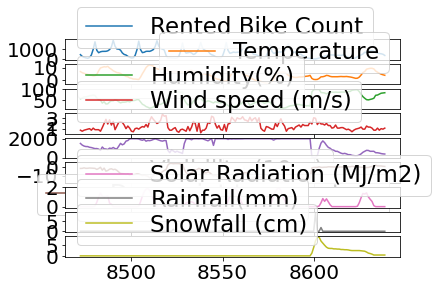

In [127]:
plt.figure(figsize = (10, 10))
data_2.plot(subplots=True)
plt.show()